# Build an End2End baseline REAL FAST with fastai

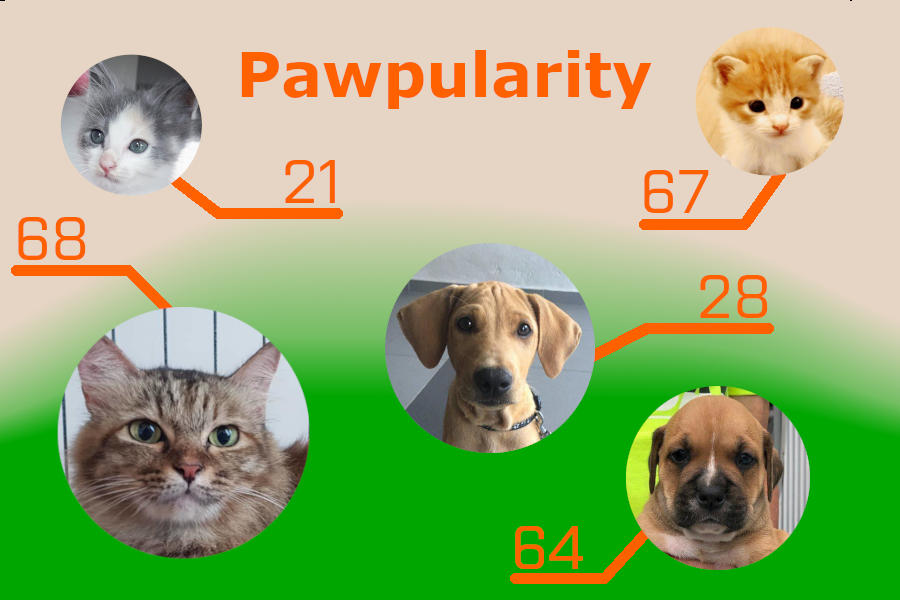

In this competiton, we try to tackle the regression task which predicts the numeric values called `Pawpularity` from the images.

In this notebook, we try to make baseline FAST with fastai module.  
You don't need to define neither datasets nor dataloaders by yourself.  

---
## Preparation
First of all, import EVERYTHING with ONE line.  
It's ok to use `*` because fastai module automatically select what we need.  

In [ ]:
from fastai.vision.all import *

In [ ]:
path = Path('/kaggle/input/petfinder-pawpularity-score/')
path.ls()

### Loading metadata
This is baseline so we only care about `Id` column which guild us to the filepath of the input images.

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head(5)

### Defining `DataBlock`
As mentioned before, we don't need to define neither datasets nor dataloaders.  
All you need to do is just selecting class and function for DataBlock parameters from fastai reference.

- **blocks**  
At this competition, we predict numerical value called "Pawpularity" from image.  
That means you should select `ImageBlock` and `RegressionBlock` for `blocks`  
- **get_x**  
Image path is provided in `Id` column of train.csv.  
You can give image path to the `DataBlock` by defining function that takes a row from dataframe and returns filepath. 
- **get_y**  
Label is provided in `Pawpularity` column of train.csv.  
You can give label to the `DataBlock` by defining function like we did for `get_x` parameter.
- **item_tfms**, **batch_tfms**  
tfms means transform, you can specify some transform you want to apply.
- **splitter**  
Here you can specify how to split train data and valid data.  
<!-- You can also specify it by giving each indices as tuple. -->

In [ ]:
def get_x(r): return path/'train'/(r['Id']+'.jpg')
def get_y(r): return r['Pawpularity'] 
db = DataBlock(blocks=(ImageBlock, RegressionBlock), 
               item_tfms=RandomResizedCrop(128, min_scale=0.35), 
               batch_tfms=Normalize,
               get_x=get_x, get_y=get_y,
               splitter=TrainTestSplitter(test_size=0.2, random_state=42))

Now we have `DataBlock` that works.  
Let's get dataloaders from `DataBlock`, then check what their batch have.

In [ ]:
dls = db.dataloaders(df)
dls.show_batch(nrows=2, ncols=3)

Dataloaders are done!  

---
## Training
Now let's define a model and check if the model can process data to the output.

<!-- maybe setting y_range to -1 ~ +1 does work?? -->

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(0, 100))
learn.model.cuda()
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

Defining model is done!  

Before starting training, let's find better learning rate.

In [ ]:
res = learn.lr_find(stop_div=False)
min_grad_lr, steep_grad_lr = res.lr_min, res.lr_steep

Now we know good learning rate then let's train the model!  
fastai's learner has function to execute fine tuning (pretrained with ImageNet).  
You don't have to freeze the model's weights explicitly.  

In [ ]:
learn.fine_tune(10, base_lr=min_grad_lr)
learn.export('resnet18.pkl')

---
## Inference
Prediction looks not good for now, but we submit it anyway.  
To do that, we give filepath to `learn.dls.test_dl` and let the learner predicts.

In [ ]:
df_t = pd.read_csv(path/'test.csv')
fnames = [path/'test'/(x+'.jpg') for x in df_t['Id']]
pred, _ = learn.get_preds(dl=learn.dls.test_dl(fnames, bs=128))
sub = pd.read_csv(path/'sample_submission.csv')
sub['Pawpularity'] = pred.flatten().tolist()
sub.to_csv('submission.csv', index=False)
sub